In [1]:
# torch
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2 as T
from torchsummary import summary
import webbrowser
import subprocess
import matplotlib.pyplot as plt
import time

# paths
import os
import sys

# set paths
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root_path)

# set random
import random # noqa: E402

# my imports
from datasets.voc_subset import VOCSubset # noqa: E402
from models.SoSi_detection import SoSiDetectionModel # noqa: E402
from models.trainer import Trainer # noqa: E402
from models.loss import CIoU # noqa: E402
from utils.plot_utils import plot_images_from_voc_dataset  # noqa: E402

# the lifesaver
%load_ext autoreload
%autoreload 2

In [2]:
# torch setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# tb open
timestamp = time.strftime("%b-%d_%H-%M-%S")
# timestamp = 'Mar-09_18-15-05'
log_dir =os.path.join(project_root_path, 'models', 'model_logs', 'p_02',f'{timestamp}')
tb_writer = SummaryWriter(log_dir)
print(f"TensorBoard logs are saved in: {log_dir}")

TensorBoard logs are saved in: g:\My Drive\Github\Project_DL_CV\models\model_logs\p_02\Mar-09_20-09-10


In [4]:
# tb launch
port = 6010
tb = subprocess.Popen(["tensorboard", f"--logdir={log_dir}", f"--port={port}", "--host=localhost"], 
                    stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
webbrowser.open(f"http://localhost:{port}");

## P2 - Single Class, Single Instance
In this part we will train a detector for a single class, single instance per image.

### Model Construction
We begin by loading the single object, single instance (sosi) detection model, with the MobilNet V3 Backbone.

In [5]:
# build SoSi Model and send to device
model = SoSiDetectionModel(final_head_conv_depth = 128).to(device)

# print the summary
summary(model, input_size = (3,224,224))

# add model graph to TB
sim_image = torch.randint(low=0, high=256, size=(1, 3, 224, 224), dtype=torch.float32).to(device)
tb_writer.add_graph(model, sim_image)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

### Dataset
Next, we load the `subset` dataset with the single class `cat` and split for train and validation. Since we have only ~1000 images we won't split into 3 (test).

In [6]:
# define the selected class
selected_class_name = "cat"

# load the file containing the indices of images with the selected class
indices_file = os.path.join("..","datasets", f"VOC_{selected_class_name}_selected_indices.pth")
class_idx = torch.load(indices_file)

##### Dataset augmentation and train-val split
We have ~1084 instances of the selected class `cat`. To better train the model, we would augment them with additional `k` times the dataset length of random images that are not from this class, to add some negative examples.

The total set of images `aug_idx` will be randomly split to train and valid.

In [7]:
# augment 
k = 4
available_idx = set(range(11540)) - set(class_idx)
aug_idx = random.sample(available_idx, min(k * len(class_idx), len(available_idx))) + class_idx
print(f'Total of {len(aug_idx)} samples, of which {len(class_idx)} contain the selected class {selected_class_name}.')

# split the indices to a train-valid ratio randomly
split_ratio = 0.8
random.shuffle(aug_idx)
train_size = int(split_ratio * len(aug_idx))
train_idx = aug_idx[:train_size] 
val_idx = aug_idx[train_size:] 

print(f'Train indices of length {len(train_idx)} and val indices of length {len(val_idx)}.')

Total of 5420 samples, of which 1084 contain the selected class cat.
Train indices of length 4336 and val indices of length 1084.


#### Transforms
Before bulding the dataset we need to define transformations on the data using `get_trainsform`. 

This function has two modes: train = `True` for training and `False` for validation and inference. In train mode, we will add additional agumentations to enhance the training robustness. 

In inference \ validation, only the basic data transformations from the model backbone defaults are executed.

In [8]:
def get_transform(train, backbone_transforms):
    transforms = []    
    # standard transforms - resizing and center cropping for 1:1 aspect ratio and 224 size
    transforms.append(T.Resize(size = backbone_transforms.crop_size, interpolation = backbone_transforms.interpolation))
    transforms.append(T.RandomCrop(size=backbone_transforms.crop_size))
    # transforms.append(T.SanitizeBoundingBoxes(labels_getter = None)) # dont sanitize labls for now
    
    # if training mode, add flips and jitters
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5)),
        transforms.append(T.RandomRotation(10)),
        transforms.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2))
    
    # standard transforms - normalizing
    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float32, scale=True)) # scale to 0-1
    transforms.append(T.Normalize(mean = backbone_transforms.mean, std = backbone_transforms.std))
    
    return T.Compose(transforms)

### Datasets
Build two datasets, each with the appropriate transformations and indices. 

In [9]:
# training dataset
train_dataset = VOCSubset(
    indices_list = train_idx,
    selected_class = selected_class_name,
    single_instance = True,
    transforms = get_transform(train = True, backbone_transforms=model.backbone_transforms()),
    download = False
)

# validation dataset
val_dataset = VOCSubset(
    indices_list = val_idx, 
    selected_class = selected_class_name,
    single_instance = True,
    transforms = get_transform(train = False, backbone_transforms=model.backbone_transforms())
)

print(f'Train dataset of length {len(train_dataset)} and val dataset of length {len(val_dataset)}.')

Train dataset of length 4336 and val dataset of length 1084.


#### Test Dataset
We would like to see that the dataset includes these samples and bounding boxes.

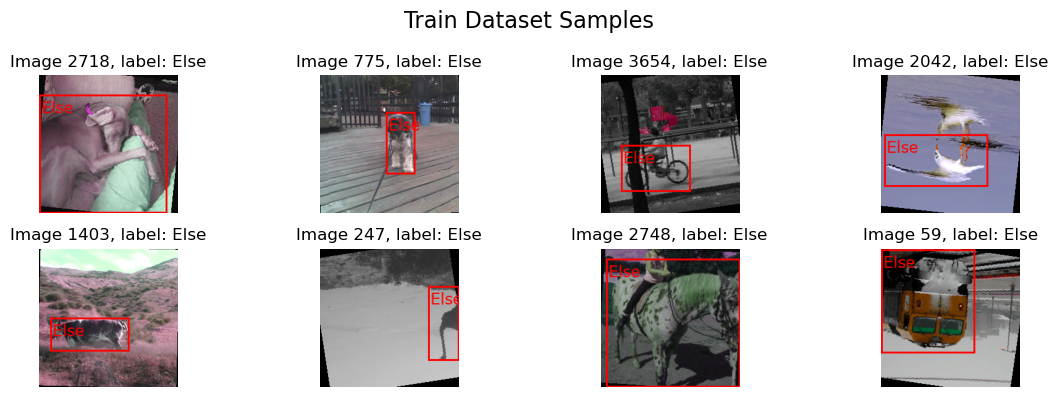

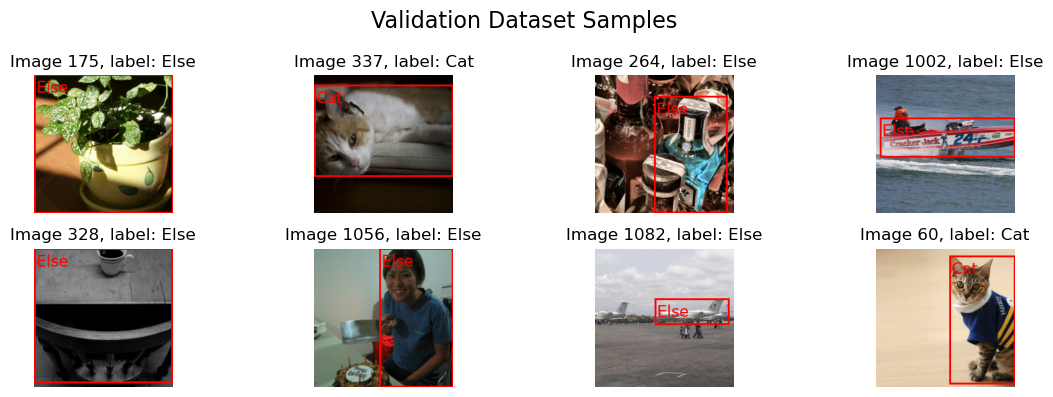

In [10]:
plot_images_from_voc_dataset(train_dataset, num_images=8, title="Train Dataset Samples")
plot_images_from_voc_dataset(val_dataset, num_images=8, title="Validation Dataset Samples")

#### Build data loaders:

In [11]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    pin_memory=True,
    drop_last = False
)

val_dataloader= torch.utils.data.DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    pin_memory=True,
    drop_last = False
)

### Training Preparation

First, we specify the learning hyperparameters.

In [12]:
# learning rate
lr = 1e-3
lr_scheduler_step = 5
lr_gamma = 0.5

##### Construct Optimizer and Scheduler 

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=1e-6)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_scheduler_step, lr_gamma)

##### Construct loss functions
We will use `CrossEntropyLoss` for the classes (with from_logits = `True` as we do not apply softmax in the model), and `MSE` for the bounding box point loss.

In [14]:
# boxes_loss_f = torch.nn.SmoothL1Loss() 
# boxes_loss_f = torch.nn.MSELoss()
boxes_loss_f = CIoU(format = 'xywh', reduction='mean')
class_loss_f = torch.nn.BCEWithLogitsLoss() 
losses = [boxes_loss_f, class_loss_f]

### Training loop

In [15]:
experiment_details = (
    f"Model Name: SoSi\n"
    f"Timestamp: {timestamp}\n"
    f"Bounding Box Loss: {boxes_loss_f}\n"
    f"Classification Loss: {class_loss_f}\n"
    f"Optimizer: Adam(lr={lr}, weight_decay=1e-4)\n"
    f"LR Scheduler: StepLR(step={lr_scheduler_step}, gamma={lr_gamma})\n"
    f"Learning Rate: {lr}\n"
    f"Augmentation Factor (k): {k}\n"
    f"Selected Class: {selected_class_name}"
)

tb_writer.add_text("Experiment details", experiment_details)

In [16]:
trainer = Trainer(device, model, optimizer, train_dataloader, val_dataloader, losses, tb_writer, lr_scheduler = lr_scheduler)

In [17]:
final_img_grid = trainer.train(max_epochs = 30, log_images_every = 2, mask_single_object = True)

Validation Epoch 30: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


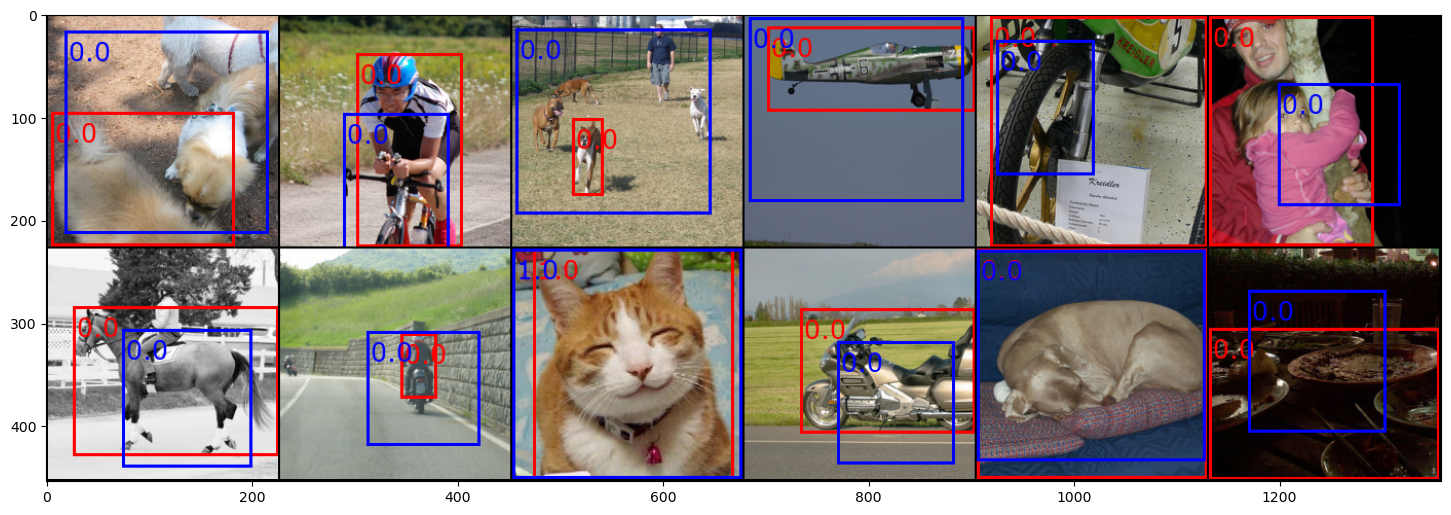

In [18]:
_, ax = plt.subplots(figsize=(18, 9))
ax.imshow(final_img_grid.permute(1, 2, 0));

Clean up and save

In [20]:
# tb.terminate()
torch.save(model.state_dict(), f"p02_model_{timestamp}.pth")  